# Working with Key/Value Pairs

Key/value RDDs are commonly used to perform aggregations, and often we will do some initial ETL (extract, transform, and load) to get our data into a key/value format. 

Key/value RDDs expose new operations (e.g., counting up reviews for each product, grouping together data with the same key, and grouping together two different RDDs).

**partitioning:**

Advanced feature that lets users control the layout of pair RDDs across nodes.

Using controllable partitioning: 
applications can sometimes greatly reduce communication costs by ensuring that data will be accessed together and will be on the same node. This can provide significant speedups.

Choosing the right partitioning for a distributed dataset is similar to choosing the right data structure for a local one—in both cases, data layout can greatly affect performance.

**pair RDDs**:

RDDs containing key/value pairs.

They expose operations that allow you to **act on each key in parallel** or **regroup data
across the network**. 

pair RDDs have a `reduceByKey()` method that can aggregate data separately for each key

a `join()` method that can merge two RDDs together by grouping elements with the same key. 

It is common to **extract fields** from an RDD (representing, for instance, an event time, customer ID, or other identifier) and use those fields as keys in pair RDD operations.

## Creating Pair RDDs

There are a number of ways to get pair RDDs in Spark. 

* Many formats we explore loading will *directly* return pair RDDs for their key/value data.
* In other cases we have a regular RDD that we want to turn into a pair RDD. We can do this by running a `map()` function that returns key/value pairs. 

We show code that starts with an *RDD of lines of text* and *keys the data by the first word in each line*.

The way to build key-value RDDs differs by language. 

In Python, for the functions on keyed data to work we need to return an RDD composed of *tuples*:

In [1]:
pairs = lines.map(lambda x: (x.split(" ")[0], x))

NameError: name 'lines' is not defined

In Scala, for the functions on keyed data to be available, we also need to return tuples. An implicit conversion on RDDs of tuples exists to provide the additional key/value functions.

In [2]:
val pairs = lines.map(x => (x.split(" ")(0), x))

SyntaxError: invalid syntax (<ipython-input-2-b2a90fe9e79b>, line 1)

Java doesn’t have a built-in tuple type, so Spark’s Java API has users create tuples using the `scala.Tuple2` class:
Java users can construct a new tuple by writing new `Tuple2(elem1, elem2)` and can then access its elements with the `._1()` and `._2()` methods.

Java users also need to call special versions of Spark’s functions when creating pair RDDs. For instance, the `mapToPair()` function should be used in place of the basic `map()` function. 

In [3]:
PairFunction<String, String, String> keyData =
new PairFunction<String, String, String>() {
public Tuple2<String, String> call(String x) {
return new Tuple2(x.split(" ")[0], x);
}
};

SyntaxError: invalid syntax (<ipython-input-3-6998b1657edd>, line 1)

When creating a pair RDD from an in-memory collection in Scala and Python, we only need to call `SparkContext.parallelize()` on a collection of pairs. To create a pair RDD in Java from an in-memory collection, we instead use `SparkContext.parallelizePairs()`.

## Transformations on Pair RDDs

Pair RDDs are allowed to use all the transformations available to standard RDDs. 
Since pair RDDs contain tuples, we need to pass *functions that operate on tuples* rather than on individual elements.

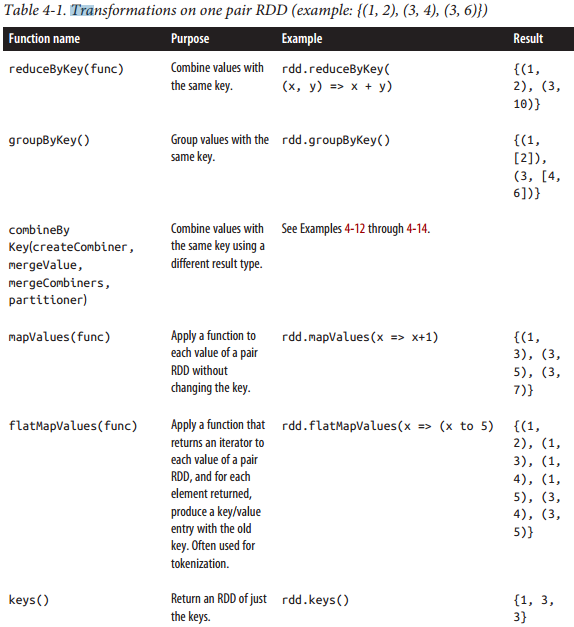

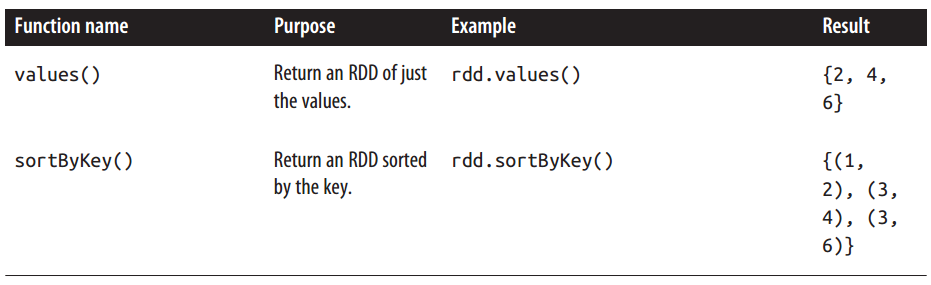

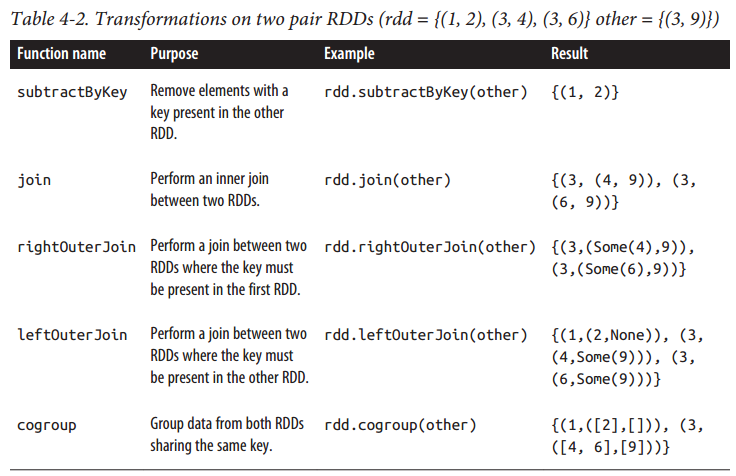

Pair RDDs are also still RDDs (of `Tuple2` objects in Java/Scala or of Python tuples), and thus support the same functions as RDDs. For instance, we can take our pair RDD from the previous section and filter out lines longer than 20 characters.

In [5]:
// Simple filter on second element in Python
result = pairs.filter(lambda keyValue: len(keyValue[1]) < 20)

NameError: name 'pairs' is not defined

In [7]:
// Simple filter on second element in Scala
pairs.filter{case (key, value) => value.length < 20}

SyntaxError: invalid syntax (<ipython-input-7-1ef2f682e02e>, line 1)

In [8]:
// Simple filter on second element in Java

Function<Tuple2<String, String>, Boolean> longWordFilter =
new Function<Tuple2<String, String>, Boolean>() {
public Boolean call(Tuple2<String, String> keyValue) {
return (keyValue._2().length() < 20);
}
};
JavaPairRDD<String, String> result = pairs.filter(longWordFilter);

SyntaxError: invalid syntax (<ipython-input-8-9c7f266a6662>, line 1)

Sometimes working with pairs can be awkward if we want to **access only the value part of our pair RDD**. Since this is a common pattern, Spark provides the `mapValues(func)` function, which is the same as `map{case (x, y): (x, func(y))}`.

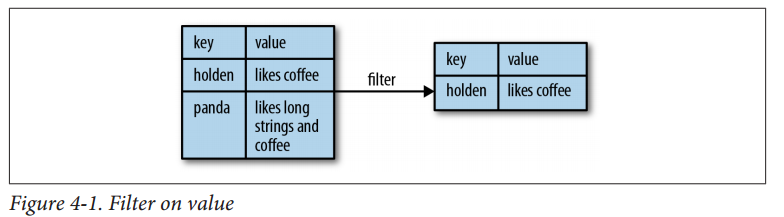

We now discuss each of the families of pair RDD functions

### Aggregations

It is common to want to **aggregate statistics across all elements with the same key**. 

We have looked at the `fold()`, `combine()`, and `reduce()` actions on basic RDDs.

Spark has a similar set of operations that combines values that have the same key. 

These operations *return RDDs* and thus are **transformations** rather than actions.

`reduceByKey()` is quite similar to `reduce()`; both take a function and use it to combine values. 

`reduceByKey()` runs several parallel reduce operations, *one for each key in the dataset*, where each operation **combines values that have the same key**. Because datasets can have very large numbers of keys, `reduceByKey()` is **not implemented as an action that returns a value to the user program**. Instead, **it returns a new RDD consisting of each key and the reduced value for that key**.

`foldByKey()` is quite similar to `fold()`; both **use a zero value of the same type** of the data in our RDD and combination function. As with `fold()`, the provided zero value for `foldByKey()` should have no impact when added with your combination function to another element.

we can use `reduceByKey()` along with `mapValues()` to compute the per-key average in a very similar manner to how `fold()` and `map()` can be used to compute the entire RDD average. 

In [21]:
# Per-key average with reduceByKey() and mapValues() in Python
rdd.mapValues(lambda x: (x, 1)).reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))

// Per-key average with reduceByKey() and mapValues() in Scala
rdd.mapValues(x => (x, 1)).reduceByKey((x, y) => (x._1 + y._1, x._2 + y._2))

SyntaxError: invalid syntax (<ipython-input-21-ad0429c41f73>, line 4)

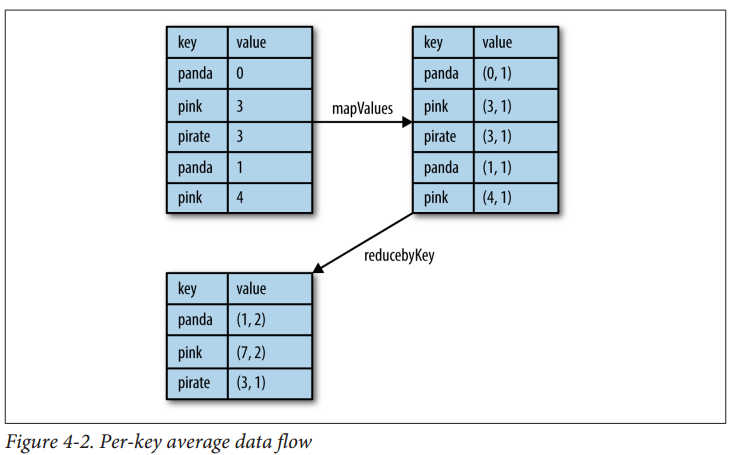

Those familiar with the combiner concept from MapReduce should note that calling `reduceByKey()` and `foldByKey()` will automatically perform combining locally on each machine before computing global totals for each key. The user does not need to specify a combiner. The more general `combineByKey()` interface allows you to customize combining behavior.

We can use a similar approach to also implement the classic distributed **word count problem**. We will use `flatMap()` from the previous chapter so that we can produce a pair RDD of **(words, the number 1)** and then sum together all of the words using `reduceByKey()`

In [1]:
# Example 4-9. Word count in Python
rdd = sc.textFile("s3://...")
words = rdd.flatMap(lambda x: x.split(" "))
result = words.map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y)


// Example 4-10. Word count in Scala
val input = sc.textFile("s3://...")
val words = input.flatMap(x => x.split(" "))
val result = words.map(x => (x, 1)).reduceByKey((x, y) => x + y)


Example 4-11. Word count in Java
JavaRDD<String> input = sc.textFile("s3://...")
JavaRDD<String> words = rdd.flatMap(new FlatMapFunction<String, String>() {
public Iterable<String> call(String x) { return Arrays.asList(x.split(" ")); }
});
JavaPairRDD<String, Integer> result = words.mapToPair(
new PairFunction<String, String, Integer>() {
public Tuple2<String, Integer> call(String x) { return new Tuple2(x, 1); }
}).reduceByKey(
new Function2<Integer, Integer, Integer>() {
public Integer call(Integer a, Integer b) { return a + b; }
});

SyntaxError: invalid syntax (<ipython-input-1-b336cee938f6>, line 7)

We can actually implement word count even faster by using the `countByValue()` function on the first RDD: 

In [2]:
input.flatMap(x => x.split(" ")).countByValue().

SyntaxError: invalid syntax (<ipython-input-2-771211ff4ede>, line 1)

`combineByKey()` is the most general of the per-key aggregation functions. 

Like `aggregate()`, `combineByKey()` allows the user to return values that are not the same type as our input data.

As `combineByKey()` goes through **the elements in a partition**, each element either: 

* has a key it hasn’t seen before (in that partition). 
* has the same key as a previous element (in that partition).

If it’s a new element: 

`combineByKey()` uses a function we provide, called `createCombiner()`, to **create the initial value for the accumulator on that key**. 

***This happens the first time a key is found in each partition, rather than only the first time the key is found in the RDD***.

If it is a value we have seen before while processing **that partition**: 

it will instead use the provided function, `mergeValue()`, with *the current value for the accumulator for that key* and *the new value*.

Since *each partition is processed independently*, we can have **multiple accumulators** for the same key. When we are merging the results from each partition, if two or more partitions **have an accumulator for the same key** we merge the accumulators using the user-supplied `mergeCombiners()` function.

We can disable map-side aggregation in `combineByKey()` if we know that our data won’t benefit from it. For example, `groupByKey()` disables map-side aggregation as the aggregation function
(appending to a list) does not save any space. If we want to disable map-side combines, we need to specify the partitioner; for now you can just use the partitioner on the source RDD by passing `rdd.partitioner`.

Since `combineByKey()` has a lot of different parameters it is a great candidate for an explanatory example. To better illustrate how `combineByKey()` works, we will look at *computing the average value for each key*

In [3]:
# Example 4-12. Per-key average using combineByKey() in Python
sumCount = nums.combineByKey((lambda x: (x,1)),
                            (lambda x, y: (x[0] + y, x[1] + 1)),
                            (lambda x, y: (x[0] + y[0], x[1] + y[1])))

sumCount.map(lambda key, xy: (key, xy[0]/xy[1])).collectAsMap()

// Example 4-13. Per-key average using combineByKey() in Scala
val result = input.combineByKey(
(v) => (v, 1),
(acc: (Int, Int), v) => (acc._1 + v, acc._2 + 1),
(acc1: (Int, Int), acc2: (Int, Int)) => (acc1._1 + acc2._1, acc1._2 + acc2._2)
).map{ case (key, value) => (key, value._1 / value._2.toFloat) }
result.collectAsMap().map(println(_))


// Example 4-14. Per-key average using combineByKey() in Java
public static class AvgCount implements Serializable {
public AvgCount(int total, int num) { total_ = total; num_ = num; }
public int total_;
public int num_;
public float avg() { return total_ / (float) num_; }
}
Function<Integer, AvgCount> createAcc = new Function<Integer, AvgCount>() {
public AvgCount call(Integer x) {
return new AvgCount(x, 1);
}
};
Function2<AvgCount, Integer, AvgCount> addAndCount =
new Function2<AvgCount, Integer, AvgCount>() {
public AvgCount call(AvgCount a, Integer x) {
a.total_ += x;
a.num_ += 1;
return a;
}
};
Function2<AvgCount, AvgCount, AvgCount> combine =
new Function2<AvgCount, AvgCount, AvgCount>() {
public AvgCount call(AvgCount a, AvgCount b) {
a.total_ += b.total_;
a.num_ += b.num_;
return a;
}
};
AvgCount initial = new AvgCount(0,0);
JavaPairRDD<String, AvgCount> avgCounts =
nums.combineByKey(createAcc, addAndCount, combine);
Map<String, AvgCount> countMap = avgCounts.collectAsMap();
for (Entry<String, AvgCount> entry : countMap.entrySet()) {
System.out.println(entry.getKey() + ":" + entry.getValue().avg());
}

SyntaxError: invalid syntax (<ipython-input-3-762d2489ceed>, line 8)

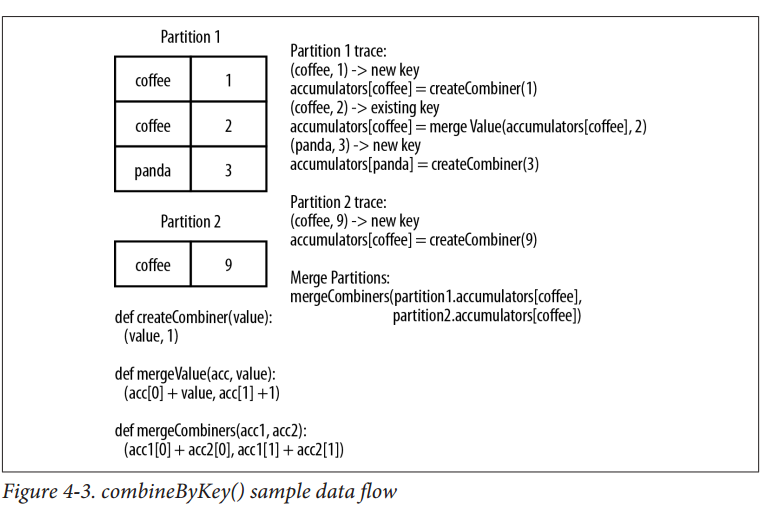

There are many options for combining our data by key. Most of them are implemented on top of `combineByKey()` but provide a simpler interface. In any case, *using one of the specialized aggregation functions in Spark can be much faster than the naive approach of grouping our data and then reducing it*.

### Tuning the level of parallelism

we have talked about: how all of our transformations are distributed

we have not really looked at *how Spark decides how to split up the work*.

Every RDD has **a fixed number of** ***partitions*** that determine the *degree of parallelism* to use when executing operations on the RDD.

When performing aggregations or grouping operations, we can *ask Spark to use a specific number of partitions*. 

Spark will always try to infer a **sensible default value based on the size of your cluster**, but in some cases you will want to tune the level of parallelism for better performance.

Most of the operators accept a *second parameter* giving the **number of partitions to use when creating the grouped or aggregated RDD**

In [4]:
# Example 4-15. reduceByKey() with custom parallelism in Python
data = [("a", 3), ("b", 4), ("a", 1)]
sc.parallelize(data).reduceByKey(lambda x, y: x + y) # Default parallelism
sc.parallelize(data).reduceByKey(lambda x, y: x + y, 10) # Custom parallelism

// Example 4-16. reduceByKey() with custom parallelism in Scala
val data = Seq(("a", 3), ("b", 4), ("a", 1))
sc.parallelize(data).reduceByKey((x, y) => x + y) // Default parallelism
sc.parallelize(data).reduceByKey((x, y) => x + y, 10) // Custom parallelism

SyntaxError: invalid syntax (<ipython-input-4-c41df8211902>, line 6)

`repartition()`:
* Change the partitioning of an RDD *outside the context of grouping and aggregation operations*. 

* It shuffles the data across the network to create a new set of partitions. 

* Repartitioning your data is a fairly expensive operation.

`coalesce()`:

* Optimized version of `repartition()` 
* Allows avoiding data movement, but **only if you are decreasing the number of RDD partitions**. 

To know whether you can safely call `coalesce()`, you can check the size of the RDD using `rdd.partitions.size()` in Java/Scala and `rdd.getNumPartitions()` in Python and make sure that you are coalescing it to fewer partitions than it currently has.

### Grouping Data

If our **data is already keyed** in the way we want, `groupByKey()` will group our data using the key in our RDD. 

On an RDD consisting of keys of type `K` and values of type `V`, we get back an RDD of type `[K, Iterable[V]]`.

`groupBy()` works on **unpaired data** or **data where we want to use a different condition besides equality on the current key**. 

It *takes a function* that it applies to **every element in the source RDD and uses the result to determine the key**.

If you find yourself writing code where you `groupByKey()` and then use a `reduce()` or `fold()` on the values, you can probably achieve the same result more efficiently by using one of the **per-key aggregation functions**. 

`groupByKey().reduce()` ==> per-key aggregation functions


Rather than reducing the RDD to an inmemory value, we reduce the data per key and get back an RDD
with the reduced values corresponding to each key. For example, `rdd.reduceByKey(func)` produces the same RDD as `rdd.groupByKey().mapValues(value => value.reduce(func))` but is **more efficient as it avoids the step of creating a list of values for each key**.

`cogroup()`:

group data **sharing the same key** from **multiple RDDs**. 

`cogroup()` over two RDDs sharing the same key type, `K`, with the respective value types `V` and `W` gives us back `RDD[(K, (Iterable[V], Iterable[W]))]`. 


If one of the RDDs doesn’t have elements for a given key that is present in the other RDD, the corresponding `Iterable` is simply **empty**. `cogroup()` gives us the power to **group data from multiple RDDs**.

`cogroup()` is used as a building block for the joins.

`cogroup()` can be used for much more than just implementing joins. 

We can also use it to implement **intersect by key**. Additionally, `cogroup()` can work on three or more RDDs at once.

### Joins

We have a full range of options including *right and left outer joins, cross joins, and inner joins*.

Inner join: 

Only keys that are present in both pair RDDs are output. When there are multiple values for the same key in one of the inputs, the resulting pair RDD will have an entry for every possible pair of values with that key from the two input RDDs.

In [5]:
// Scala shell inner join

storeAddress = {
(Store("Ritual"), "1026 Valencia St"), (Store("Philz"), "748 Van Ness Ave"),
(Store("Philz"), "3101 24th St"), (Store("Starbucks"), "Seattle")}

storeRating = {
(Store("Ritual"), 4.9), (Store("Philz"), 4.8))}

storeAddress.join(storeRating) == {
(Store("Ritual"), ("1026 Valencia St", 4.9)),
(Store("Philz"), ("748 Van Ness Ave", 4.8)),
(Store("Philz"), ("3101 24th St", 4.8))}

SyntaxError: invalid syntax (<ipython-input-5-37a16d6d7eb9>, line 1)

Sometimes we don’t need the key to be present in both RDDs to want it in our result:

For example, if we were joining customer information with recommendations we might not want to drop customers if there were not any recommendations yet. 

`leftOuterJoin(other)` and `rightOuterJoin(other)` both join pair RDDs together by key, where one of the pair RDDs can be missing the key.

With `leftOuterJoin()` the resulting pair RDD has entries for each key in the source RDD. 

The value associated with each key in the result is a tuple of the value from the source RDD and an `Option` (or `Optional` in Java) for the value from the other pair RDD. 

In Python, if a value isn’t present `None` is used; and if the value is present the regular value, without any wrapper, is used. As with `join()`, we can have multiple entries for each key; when this occurs, we get the Cartesian product between the two lists of values.

`Optional` is part of Google’s Guava library and represents a possibly missing value. We can check `isPresent()` to see if it’s set, and `get()` will return the contained instance provided data is present.

`rightOuterJoin()` is almost identical to `leftOuterJoin()` except the key must be present in the **other RDD** and the tuple has an option for the source rather than the other RDD.

In [6]:
leftOuterJoin() and rightOuterJoin()

storeAddress.leftOuterJoin(storeRating) ==
{(Store("Ritual"),("1026 Valencia St",Some(4.9))),
(Store("Starbucks"),("Seattle",None)),
(Store("Philz"),("748 Van Ness Ave",Some(4.8))),
(Store("Philz"),("3101 24th St",Some(4.8)))}
storeAddress.rightOuterJoin(storeRating) ==
{(Store("Ritual"),(Some("1026 Valencia St"),4.9)),
(Store("Philz"),(Some("748 Van Ness Ave"),4.8)),
(Store("Philz"), (Some("3101 24th St"),4.8))}

SyntaxError: invalid syntax (<ipython-input-6-5311a83ba44c>, line 3)

### Sorting Data

We can sort an RDD with key/value pairs provided that there is **an ordering defined on the key**. Once we have sorted our data, any subsequent call on the sorted data to `collect()` or `save()` will result in ordered data.

The `sortByKey()` function takes a parameter called `ascending` indicating whether we want it in ascending order (it defaults to `true`).

Sometimes we want a different sort order entirely, and to support this we can provide our **own comparison function**. 

In [7]:
# Example 4-19. Custom sort order in Python, sorting integers as if strings

rdd.sortByKey(ascending=True, numPartitions=None, keyfunc = lambda x: str(x))

// Example 4-20. Custom sort order in Scala, sorting integers as if strings

val input: RDD[(Int, Venue)] = ...
implicit val sortIntegersByString = new Ordering[Int] {
override def compare(a: Int, b: Int) = a.toString.compare(b.toString)
}
rdd.sortByKey()
Example 4-21. Custom sort order in Java, sorting integers as if strings
class IntegerComparator implements Comparator<Integer> {
public int compare(Integer a, Integer b) {
return String.valueOf(a).compareTo(String.valueOf(b))
}
}
rdd.sortByKey(comp)

SyntaxError: invalid syntax (<ipython-input-7-1e1c73641492>, line 5)

### Actions Available on Pair RDDs

As with the transformations, all of the traditional actions available on the *base RDD* are also available on pair RDDs. Some additional actions are available on pair RDDs to take advantage of the key/value nature of the data:

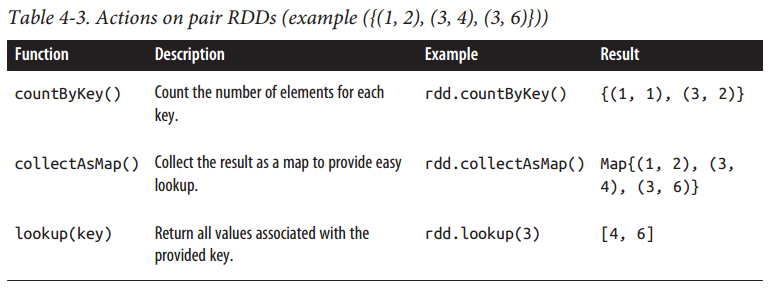

There are also multiple other actions on pair RDDs that save the RDD, which we will describe in Chapter 5.

### Data Partitioning (Advanced)

How to control datasets’ partitioning across nodes? 

In a *distributed program*, communication is very expensive, so laying out data to minimize network traffic can greatly improve performance. 

Much like how a single-node program needs to choose the right data structure for a collection of records, *Spark programs can choose to control their RDDs’ partitioning to reduce communication*. 

**Partitioning will not be helpful in all applications**—for example, if a given RDD is scanned only once, there is no point in partitioning it in advance. 

It is useful only **when a dataset is reused multiple times in key-oriented operations** such as joins.

Spark’s partitioning is available on **all RDDs of key/value pairs**, and causes the system to **group elements based on a function of each key**. 

Although Spark **does not give explicit control of which worker node each key goes to** (partly because the system is  designed to work even if specific nodes fail), it **lets the program ensure that a `set of keys` will appear together on `some node`**. 

For example, you might choose to hash-partition an RDD into 100 partitions so that keys that have **the same hash value modulo 100 appear on the same node**. Or you might range-partition the RDD into sorted ranges of keys so that **elements with keys in the same range appear on the same node**.

As a simple example, consider an application that keeps a large table of user information in memory—say, an RDD of `(UserID, UserInfo)` pairs, where `UserInfo` contains a list of topics the user is subscribed to. The application periodically *combines* this table with a smaller file representing events that happened in the past five minutes—say, a table of `(UserID, LinkInfo)` pairs for users who have clicked a link on a website in those five minutes. For example, we may wish to ***count how many users visited a link that was not to one of their subscribed topics***. 

We can perform this combination with Spark’s `join()` operation, which can be used to group the `UserInfo` and `LinkInfo` pairs for each `UserID` by key. 

In [8]:
//Example 4-22. Scala simple application

// Initialization code; we load the user info from a Hadoop SequenceFile on HDFS.
// This distributes elements of userData by the HDFS block where they are found,
// and doesn't provide Spark with any way of knowing in which partition a
// particular UserID is located.
val sc = new SparkContext(...)
val userData = sc.sequenceFile[UserID, UserInfo]("hdfs://...").persist()
// Function called periodically to process a logfile of events in the past 5 minutes;

// we assume that this is a SequenceFile containing (UserID, LinkInfo) pairs.
def processNewLogs(logFileName: String) {
val events = sc.sequenceFile[UserID, LinkInfo](logFileName)
val joined = userData.join(events)// RDD of (UserID, (UserInfo, LinkInfo)) pairs
val offTopicVisits = joined.filter {
case (userId, (userInfo, linkInfo)) => // Expand the tuple into its components
!userInfo.topics.contains(linkInfo.topic)
}.count()
println("Number of visits to non-subscribed topics: " + offTopicVisits)
}

SyntaxError: invalid syntax (<ipython-input-8-d17e0d61e1b9>, line 1)

This code will run fine as is, but it will be *inefficient*. This is because the `join()` operation, called each time `processNewLogs()` is invoked, **does not know anything about how the keys are partitioned in the datasets**. 
By default, this operation will: 
* hash all the keys of both datasets
* sending elements with the *same key hash* across the network to the same machine
* Then join together the elements with the same key on that machine. 

Because we expect the `userData` table to be much larger than the small log of events seen every five minutes, this wastes a lot of work:

the `userData` table is **hashed and shuffled across the network on every call, even though it doesn’t change.**

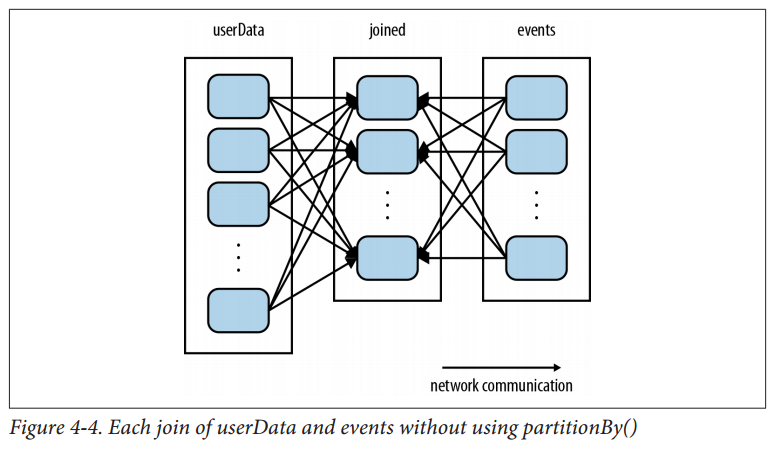

Fixing this is simple: 

just use the `partitionBy()` transformation on `userData` to hash-partition it at the start of the program. We do this by passing a `spark.HashPartitioner` object to `partitionBy`.

In [2]:
//  Scala custom partitioner
val sc = new SparkContext(...)
val userData = sc.sequenceFile[UserID, UserInfo]("hdfs://...")
.partitionBy(new HashPartitioner(100)) // Create 100 partitions
.persist()

SyntaxError: invalid syntax (<ipython-input-2-24f2ed5f437c>, line 1)

The `processNewLogs()` method can *remain unchanged*: the events RDD is local to `processNewLogs()`, and is used only once within this method, so there is no advantage in specifying a partitioner for events. Because we called `partitionBy()` when
building `userData`, Spark will now know that it is hash-partitioned, and calls to
`join()` on it will take advantage of this information. 

In particular, when we call user `Data.join(events)`, Spark **will shuffle only the events** RDD, sending events with each particular `UserID` to the machine that contains the corresponding hash partition of `userData` (see Figure 4-5). The result is that a lot less data is communicated over the network, and the program runs significantly faster.

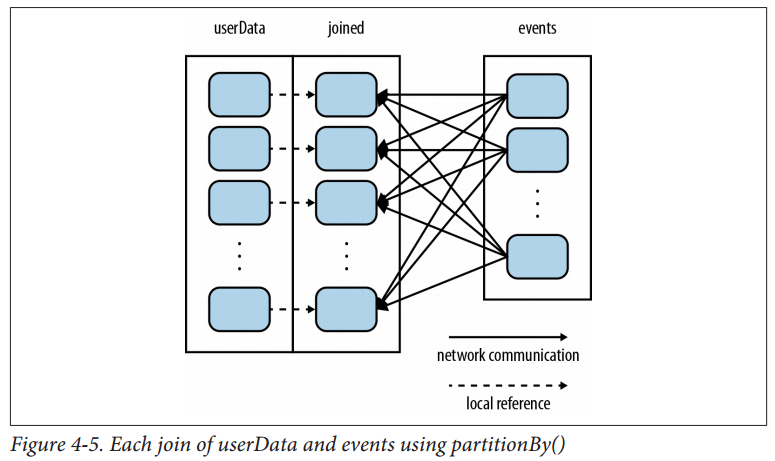

`partitionBy()` is a transformation, so it always returns a *new RDD*—it *does not change the original RDD in place*. 

**RDDs can never be modified once created**. Therefore it is important to `persist` and save as `userData` the result of `partitionBy()`, not the original `sequenceFile()`. 

Also, the 100 passed to `partitionBy()` represents the number of partitions, which will control *how many parallel tasks perform further operations on the RDD* (e.g., joins); in general, make this at least *as large as the number of cores in your cluster*.

Note

Failure to persist an RDD after it has been transformed with `partitionBy()` will cause **subsequent uses of the RDD to repeat the partitioning of the data**. Without persistence, use of the partitioned RDD will cause reevaluation of the RDDs complete lineage. That would negate the advantage of `partitionBy()`, resulting in repeated partitioning and shuffling of data across the network, similar to what occurs without any specified partitioner.

In fact, many other Spark operations automatically result in an RDD with known partitioning information, and many operations other than `join()` will take advantage of this information. 

For example, `sortByKey()` and `groupByKey()` will result in *range-partitioned* and *hash-partitioned* RDDs, respectively. 

On the other hand, operations like `map()` cause the new RDD to forget the parent’s partitioning information, because such operations could theoretically modify the key of each record.

##### Partitioning in Java and Python
Spark’s Java and Python APIs benefit from partitioning in the same way as the Scala API. However, in Python, you cannot pass a `HashPartitioner` object to `partitionBy`; instead, you just pass the number of partitions desired (e.g., `rdd.partitionBy(100)`).

##### How to determine how an RDD is partitioned, and exactly how partitioning affects the various Spark operations.

### Determining an RDD’s Partitioner

In Scala and Java, you can determine *how an RDD is partitioned* using its `partitioner` property (or `partitioner()` method in Java).

This returns a `scala.Optionobject`, which is a Scala class for a container that may or may not contain one item.

You can call `isDefined()` on the `Option` to check whether it has a value, and `get()` to
get this value. 

If present, the value will be a `spark.Partitioner` object. 

This is essentially a function telling the RDD which partition each key goes into; we’ll talk more about this later.

The `partitioner` property is a great way to test in the Spark shell **how different Spark operations affect partitioning, and to check that the operations you want to do in your program will yield the right result** 

In [3]:
//Determining partitioner of an RDD

scala> val pairs = sc.parallelize(List((1, 1), (2, 2), (3, 3)))
pairs: spark.RDD[(Int, Int)] = ParallelCollectionRDD[0] at parallelize at <console>:12
scala> pairs.partitioner
res0: Option[spark.Partitioner] = None
scala> val partitioned = pairs.partitionBy(new spark.HashPartitioner(2))
partitioned: spark.RDD[(Int, Int)] = ShuffledRDD[1] at partitionBy at <console>:14
scala> partitioned.partitioner
res1: Option[spark.Partitioner] = Some(spark.HashPartitioner@5147788d)

SyntaxError: invalid syntax (<ipython-input-3-8e5c6d268dee>, line 1)

In this short session, we created an RDD of `(Int, Int)` pairs, which initially have no partitioning information (an `Option` with value `None`). 

We then created a second RDD by `hash-partitioning` the first. If we actually wanted to use partitioned in further operations, then we should have appended `persist()` to the third line of input, in which `partitioned` is defined. This is for the same reason that we needed `persist()` for `userData` in the previous example: without `persist()`, subsequent RDD
actions will evaluate the entire lineage of partitioned, which will cause pairs to be hash-partitioned over and over.

### Operations That Benefit from Partitioning

Many of Spark’s operations involve **shuffling data by key across the network**. All of these will benefit from partitioning. As of Spark 1.0, the operations that benefit from partitioning are `cogroup(), groupWith(), join(), leftOuterJoin(), rightOuterJoin(), groupByKey(), reduceByKey(), combineByKey(), and lookup()`.